# Background

We derive expressions for the survival probability, denoted as $S(u | \theta)$, that two loci separated by $u$ units share the same most recent common ancestor for a pair of individuals, given a demographic model with parameters $\theta$.

For a constant demography, this expression can already be found in the supplementary material of [HapNe paper](10.1038/s41467-023-43522-6). However, we re-derive it here as a sanity check. 

## Under SMC

In [1]:
from sympy import *
init_printing()

Ne = Symbol('Ne', positive=True) # Diploid population size
t = Symbol('t', positive=True) # Time
u = Symbol('u', positive=True) # Distance (Morgan)
x = Symbol('x', positive=True) # Placeholder
gamma = 1 / (2*Ne) # Coalescent rate
Gamma = integrate(gamma,(x, 0, t)) # Cumulative coalescent rate
tmrca = gamma * exp(-Gamma)
# TMRCA density
Eq(symbols('f(t|\\theta)'), tmrca)

In [2]:
# Under SMC, each recombination changes ancestry
Eq(symbols('S(u|t)'), exp(-2*t*u))

In [3]:
# Survival density for distance exactly equal to u
survival = integrate(exp(-2*t*u) * tmrca, (t, 0, oo))
Eq(symbols('S(u)'), survival.simplify())

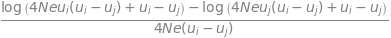

In [4]:
# Survival density for distance exactly equal to u
ui = Symbol('u_i', positive=True) # Distance (Morgan)
uj = Symbol('u_j', positive=True) # Distance (Morgan)

uniform_dist = 1 / (uj - ui)
survival_bin = integrate(survival * uniform_dist, (u, ui, uj)).simplify()
survival_bin

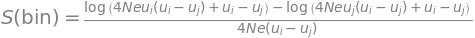

In [5]:
Eq(symbols('S(\\text{bin})'), survival_bin)

# Approximate SMC'
In practice, one would prefer a more precise approximation made in the supplementary of HapNe. 

In [6]:
# Probability of healing event
ph = 0.5 - exp(-2*Gamma) / (2*t) * integrate(exp(2*Gamma.subs({t: x})), (x, 0, t))

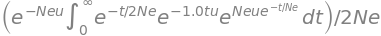

In [7]:
integrate(exp(-2*t*u*(1-ph)) * tmrca, (t, 0, oo))

We can obtain a more tractable expression by considering only $k=1$ healing events: 

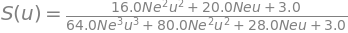

In [8]:
# Erlang PDF for k=1
v = symbols('v', real=True, positive=True)
f_erl_1 = (2*t) * exp(-2*t*v)
S_ut = exp(-2*u*t) + ph * integrate(f_erl_1 * exp(-2*t*(u-v)), (v, 0, u))
survival2 = integrate(S_ut * tmrca, (t, 0, oo))
Eq(symbols('S(u)'), survival2.simplify())

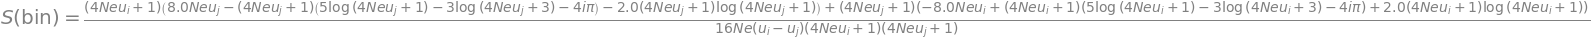

In [9]:
survival_bin2 = integrate(survival2 * uniform_dist, (u, ui, uj), manual=True).simplify()
Eq(symbols('S(\\text{bin})'), survival_bin2)

In [11]:
print(survival_bin2)

((4*Ne*u_i + 1)*(8.0*Ne*u_j - (4*Ne*u_j + 1)*(5*log(4*Ne*u_j + 1) - 3*log(4*Ne*u_j + 3) - 4*I*pi) - 2.0*(4*Ne*u_j + 1)*log(4*Ne*u_j + 1)) + (4*Ne*u_j + 1)*(-8.0*Ne*u_i + (4*Ne*u_i + 1)*(5*log(4*Ne*u_i + 1) - 3*log(4*Ne*u_i + 3) - 4*I*pi) + 2.0*(4*Ne*u_i + 1)*log(4*Ne*u_i + 1)))/(16*Ne*(u_i - u_j)*(4*Ne*u_i + 1)*(4*Ne*u_j + 1))


We note, however, that the SMC approximation seem to be very accurate for large enough Ne. 

In [10]:
import numpy as np
def f1_sympy(ne_val):
    return float(survival_bin.subs({ui: 1e-3, uj: 2e-3, Ne: ne_val}))
def f2_sympy(ne_val):
    return float(survival_bin2.subs({ui: 1e-3, uj: 2e-3, Ne: ne_val}))
f1 = np.vectorize(f1_sympy)
f2 = np.vectorize(f2_sympy)

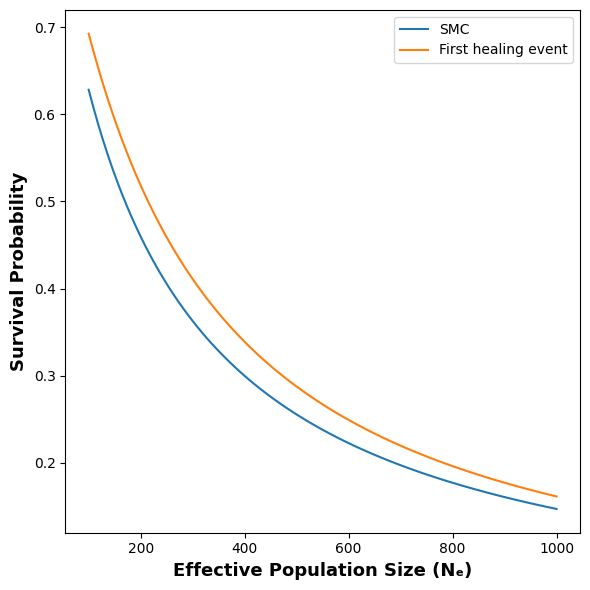

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.figure(figsize=(6, 6))

# Create data
x = np.linspace(100, 1000, 100)
y1 = f1(x)
y2 = f2(x)

# Plot with lines and markers
plt.plot(x, y1, label='SMC')
plt.plot(x, y2, label='First healing event')

# Styling
plt.xlabel('Effective Population Size (Nₑ)', fontsize=13, fontweight='bold')
plt.ylabel('Survival Probability', fontsize=13, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

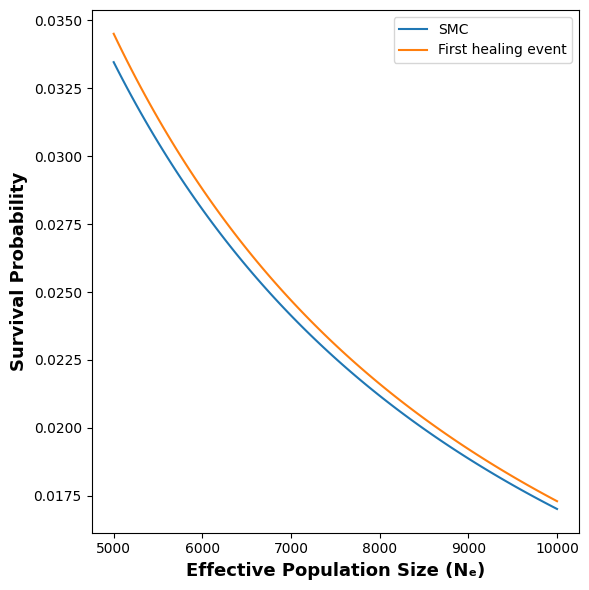

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.figure(figsize=(6, 6))

# Create data
x = np.linspace(5000, 10_000, 100)
y1 = f1(x)
y2 = f2(x)

# Plot with lines and markers
plt.plot(x, y1, label='SMC')
plt.plot(x, y2, label='First healing event')

# Styling
plt.xlabel('Effective Population Size (Nₑ)', fontsize=13, fontweight='bold')
plt.ylabel('Survival Probability', fontsize=13, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()